In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Nadam
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model


In [2]:
folder_path = 'preprocess_dataset'
files = os.listdir(folder_path)

# Lists to store features and labels
dfs = []

# Loop through all files and append them to the list
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all dataframes in the list into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

In [3]:
combined_df

,0,1,2,3,4,5,6,7,8,9,...,1996,1997,1998,1999,ID,Gender,Age,Glucose,Height,Weight
0,10.391876,10.391153,10.389717,10.387565,10.384695,10.381108,10.376805,10.371788,10.366059,10.359622,...,10.704478,10.706991,10.708921,10.710263,1,Male,38,99,180,53
1,10.711091,10.711122,10.710568,10.709428,10.707704,10.705402,10.702527,10.699086,10.695087,10.690536,...,11.191889,11.194441,11.196344,11.197595,1,Male,38,99,180,53
2,11.198235,11.198012,11.197087,11.195466,11.193152,11.190152,11.186471,11.182114,11.177084,11.171386,...,10.053162,10.055215,10.056673,10.057540,1,Male,38,99,180,53
3,10.057809,10.057404,10.056420,10.054862,10.052733,10.050040,10.046787,10.042982,10.038632,10.033745,...,11.170293,11.172574,11.174220,11.175235,1,Male,38,99,180,53
4,11.175626,11.175293,11.174360,11.172830,11.170705,11.167990,11.164692,11.160819,11.156381,11.151389,...,10.319610,10.321718,10.323245,10.324186,1,Male,38,99,180,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,4.138344,4.138098,4.137627,4.136937,4.136031,4.134919,4.133607,4.132105,4.130423,4.128569,...,4.596787,4.597435,4.597915,4.598229,23,Male,27,108,173,57
517,4.598388,4.598317,4.598084,4.597690,4.597134,4.596416,4.595535,4.594490,4.593280,4.591903,...,4.750542,4.751213,4.751722,4.752067,23,Male,27,108,173,57
518,4.752267,4.752213,4.751979,4.751560,4.750954,4.750159,4.749171,4.747986,4.746604,4.745020,...,4.521866,4.522842,4.523567,4.524033,23,Male,27,108,173,57
519,4.524242,4.524089,4.523662,4.522954,4.521958,4.520667,4.519076,4.517178,4.514970,4.512446,...,3.787424,3.787862,3.788190,3.788411,23,Male,27,108,173,57


In [4]:
# Assuming the first 2000 columns are PPG signals
ppg_signal = combined_df.iloc[:, 0:2000]

# Assuming the column for Glucose levels is named "Glucose"
label = combined_df['Glucose']

# Assuming Age, Gender, Height, and Weight are the last 4 columns
# Adjust the column indices or names as per your actual DataFrame structure
geographic_data = combined_df[['Age', 'Gender', 'Height', 'Weight']]
# geographic_data = combined_df[['Height', 'Weight']]

In [5]:
label = np.array(label)

In [6]:
# Normalize/standardize the PPG signals
scaler = StandardScaler()
ppg_signals = scaler.fit_transform(ppg_signal)

In [7]:
# Encode categorical variables and normalize geographical data
ct = ColumnTransformer([('onehot', OneHotEncoder(), ['Gender']), ('scaler', StandardScaler(), ['Age', 'Height', 'Weight'])], remainder='passthrough')
# ct = ColumnTransformer([('scaler', StandardScaler(), ['Height', 'Weight'])], remainder='passthrough')
geographical_data_transformed = ct.fit_transform(geographic_data)

In [8]:
# Split the data into training and testing sets
X_ppg_train, X_ppg_test, X_geo_train, X_geo_test, y_train, y_test = train_test_split(
    ppg_signals, geographical_data_transformed, label, test_size=0.2, random_state=42)

In [9]:
# 1D CNN model for PPG signals
input_ppg_cnn = Input(shape=(2000, 1))  # 1D CNN expects 3D input shape
x_ppg_cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(input_ppg_cnn)
x_ppg_cnn = MaxPooling1D(pool_size=2)(x_ppg_cnn)
x_ppg_cnn = Conv1D(filters=32, kernel_size=3, activation='relu')(x_ppg_cnn)
x_ppg_cnn = MaxPooling1D(pool_size=2)(x_ppg_cnn)
x_ppg_cnn = Conv1D(filters=16, kernel_size=3, activation='relu')(x_ppg_cnn)
x_ppg_cnn = MaxPooling1D(pool_size=2)(x_ppg_cnn)
x_ppg_cnn = Flatten()(x_ppg_cnn)

# Geographical data model
input_geo = Input(shape=(X_geo_train.shape[1],1))
x_geo = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_geo)
# x_geo = MaxPooling1D(pool_size=2)(x_geo)
x_geo = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x_geo)
x_geo = MaxPooling1D(pool_size=2)(x_geo)
x_geo = Flatten()(x_geo)

# Concatenate models
concat = concatenate([x_ppg_cnn, x_geo])
x = Dense(32, activation='relu')(concat)
output = Dense(1, activation='linear')(x)  # Glucose prediction

model = Model(inputs=[input_ppg_cnn, input_geo], outputs=output)

In [10]:
# Compile the model
model.compile(optimizer=Adagrad(learning_rate=0.002), loss='mse', metrics=['mae'])

In [11]:
# Train the model
history = model.fit([X_ppg_train, X_geo_train], y_train, validation_data=([X_ppg_test, X_geo_test], y_test), epochs=100, batch_size=32)

Epoch 1/100
13/13 [==============================] - 1s 30ms/step - loss: 9487.7588 - mae: 92.6221 - val_loss: 3046.9500 - val_mae: 47.1291
Epoch 2/100
13/13 [==============================] - 0s 15ms/step - loss: 2747.7021 - mae: 39.9393 - val_loss: 2540.2554 - val_mae: 35.4255
Epoch 3/100
13/13 [==============================] - 0s 18ms/step - loss: 2186.1226 - mae: 34.2861 - val_loss: 2255.9976 - val_mae: 31.8398
Epoch 4/100
13/13 [==============================] - 0s 16ms/step - loss: 1921.4916 - mae: 31.8897 - val_loss: 2102.2881 - val_mae: 29.9773
Epoch 5/100
13/13 [==============================] - 0s 18ms/step - loss: 1700.3020 - mae: 29.8124 - val_loss: 1727.9502 - val_mae: 27.7959
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 1514.0267 - mae: 27.9670 - val_loss: 1433.2134 - val_mae: 25.9476
Epoch 7/100
13/13 [==============================] - 0s 17ms/step - loss: 1347.0964 - mae: 26.6830 - val_loss: 1394.5802 - val_mae: 25.6435
Epoch 8/100
13/13 [=

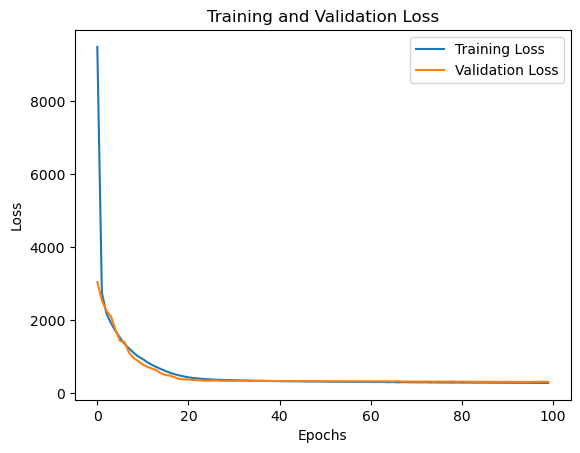

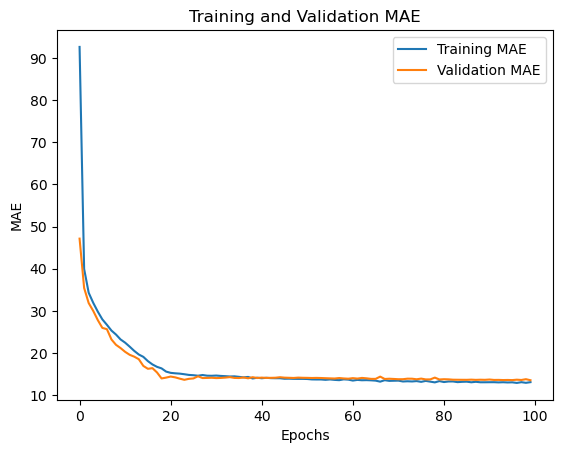

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [13]:
# Evaluate the model
evaluation = model.evaluate([X_ppg_test, X_geo_test], y_test)
print(f"Test MSE: {evaluation[0]}")
print(f"Test MAE: {evaluation[1]}")

4/4 [==============================] - 0s 15ms/step - loss: 309.0300 - mae: 13.5272
Test MSE: 309.02996826171875
Test MAE: 13.527167320251465


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predicting on the test set
y_pred = model.predict([X_ppg_test, X_geo_test])

# Calculate MSE
mae = mean_absolute_error(y_test, y_pred)
print(f"Calculated MAE: {mae}")


4/4 [==============================] - 0s 4ms/step
Calculated MAE: 13.527165876116072


In [15]:
print(y_pred[0:5])
print(y_test[0:5])

[[113.34533]
 [134.5806 ]
 [120.93096]
 [130.28574]
 [127.78916]]
[100 127  99 146 127]


In [16]:
import numpy as np

def check_iso_compliance(y_true, y_pred):
    # Convert to numpy arrays for vectorized operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate differences and percent differences
    diff = np.abs(y_pred - y_true)
    percent_diff = (diff / y_true) * 100
    
    # Conditions
    condition_low = (y_true < 100)  # Concentrations < 100 mg/dL
    condition_high = (y_true >= 100)  # Concentrations ≥ 100 mg/dL
    
    # Tolerances
    tolerance_low = diff <= 15  # ±15 mg/dL for low concentrations
    tolerance_high = percent_diff <= 15  # ±15% for high concentrations
    
    # Check compliance
    compliant_low = np.where(condition_low, tolerance_low, True)  # True for high concentrations
    compliant_high = np.where(condition_high, tolerance_high, True)  # True for low concentrations
    
    # Overall compliance
    compliant = np.logical_and(compliant_low, compliant_high)
    
    # Calculate compliance rate
    compliance_rate = np.mean(compliant)
    
    # Check if 95% are within tolerance
    is_compliant = compliance_rate >= 0.95
    
    return is_compliant, compliance_rate


In [17]:
# Evaluate ISO compliance
is_compliant, compliance_rate = check_iso_compliance(y_test, y_pred)

print(f"ISO 15197:2013 Compliance: {'Yes' if is_compliant else 'No'}")
print(f"Compliance Rate: {compliance_rate*100:.2f}%")

ISO 15197:2013 Compliance: No
Compliance Rate: 64.87%


In [18]:
def calculate_deviations(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate differences and percent differences
    diff = np.abs(y_pred - y_true)
    percent_diff = (diff / y_true) * 100
    
    # Split by concentration level
    low_concentration = y_true < 100
    high_concentration = y_true >= 100
    
    # Average deviations
    avg_dev_low = np.mean(diff[low_concentration])
    avg_dev_high = np.mean(percent_diff[high_concentration])
    
    return avg_dev_low, avg_dev_high

# Assuming y_test and y_pred are defined
avg_dev_low, avg_dev_high = calculate_deviations(y_test, y_pred)
print(f"Average deviation for <100 mg/dL: {avg_dev_low} mg/dL")
print(f"Average percentage deviation for ≥100 mg/dL: {avg_dev_high}%")


Average deviation for <100 mg/dL: 14.627553054082961 mg/dL
Average percentage deviation for ≥100 mg/dL: 13.372600527593162%


In [167]:
def calculate_deviations(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate differences and percent differences
    diff = np.abs(y_pred - y_true)
    percent_diff = (diff / y_true) * 100
    
    # Split by concentration level
    low_concentration = y_true < 100
    high_concentration = y_true >= 100
    
    # Average deviations
    avg_dev_low = np.mean(diff[low_concentration])
    avg_dev_high = np.mean(percent_diff[high_concentration])
    
    return avg_dev_low, avg_dev_high

# Assuming y_test and y_pred are defined
avg_dev_low, avg_dev_high = calculate_deviations(y_test, y_pred)
print(f"Average deviation for <100 mg/dL: {avg_dev_low} mg/dL")
print(f"Average percentage deviation for ≥100 mg/dL: {avg_dev_high}%")


Average deviation for <100 mg/dL: 14.83666689046224 mg/dL
Average percentage deviation for ≥100 mg/dL: 14.040427905433328%


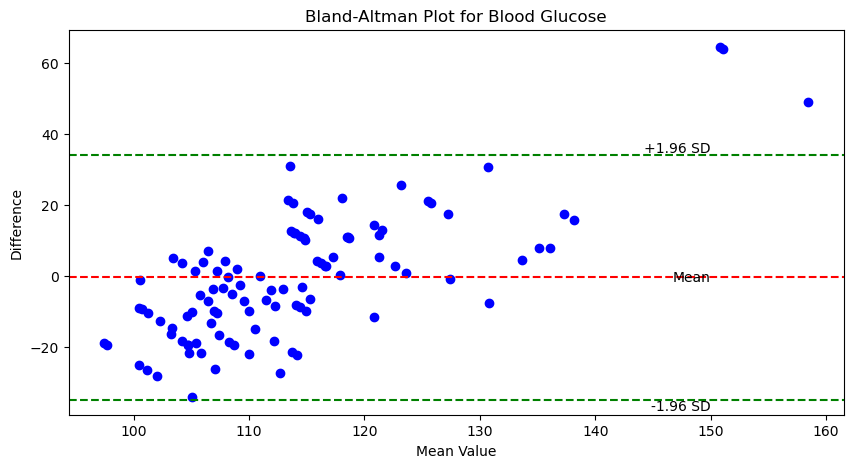

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2                   # Difference between data1 and data2
    md = np.mean(diff)                     # Mean of the difference
    sd = np.std(diff, axis=0)              # Standard deviation of the difference
    
    plt.scatter(mean, diff, *args, **kwargs)  # Scatter plot
    plt.axhline(md,           color='red', linestyle='--')            # Mean line
    plt.axhline(md + 1.96*sd, color='green', linestyle='--')            # Upper limit of agreement
    plt.axhline(md - 1.96*sd, color='green', linestyle='--')            # Lower limit of agreement
    plt.text(150, md, 'Mean', va='center', ha='right')            # Text for mean line
    plt.text(150, md + 1.96*sd, '+1.96 SD', va='bottom', ha='right')  # Text for upper limit
    plt.text(150, md - 1.96*sd, '-1.96 SD', va='top', ha='right')     # Text for lower limit

data1 = y_test  # Random data around 100 with noise
data2 = np.squeeze(y_pred)  # Random data around data1 with noise

# Create Bland-Altman Plot
plt.figure(figsize=(10, 5))
bland_altman_plot(data1, data2, color='blue')
plt.title('Bland-Altman Plot for Blood Glucose')
plt.xlabel('Mean Value')
plt.ylabel('Difference')
plt.show()


In [21]:
data1.shape

(105,)

In [22]:
data2.shape

(105, 1)